In [2]:
# Section 1: Setup and Preparation (Mount Google Drive, Install Libraries, and Import Modules)

# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Install necessary libraries (if not already installed)
!pip install pandas matplotlib openpyxl

# Step 3: Import the libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter

Mounted at /content/drive


<ipython-input-4-e09e43479474>:126: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_inset.set_xticklabels(months, rotation=90)


Plot saved to: /content/drive/My Drive/colab/fig3_hydrograph/fig3_hydrograph.png


<ipython-input-4-e09e43479474>:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


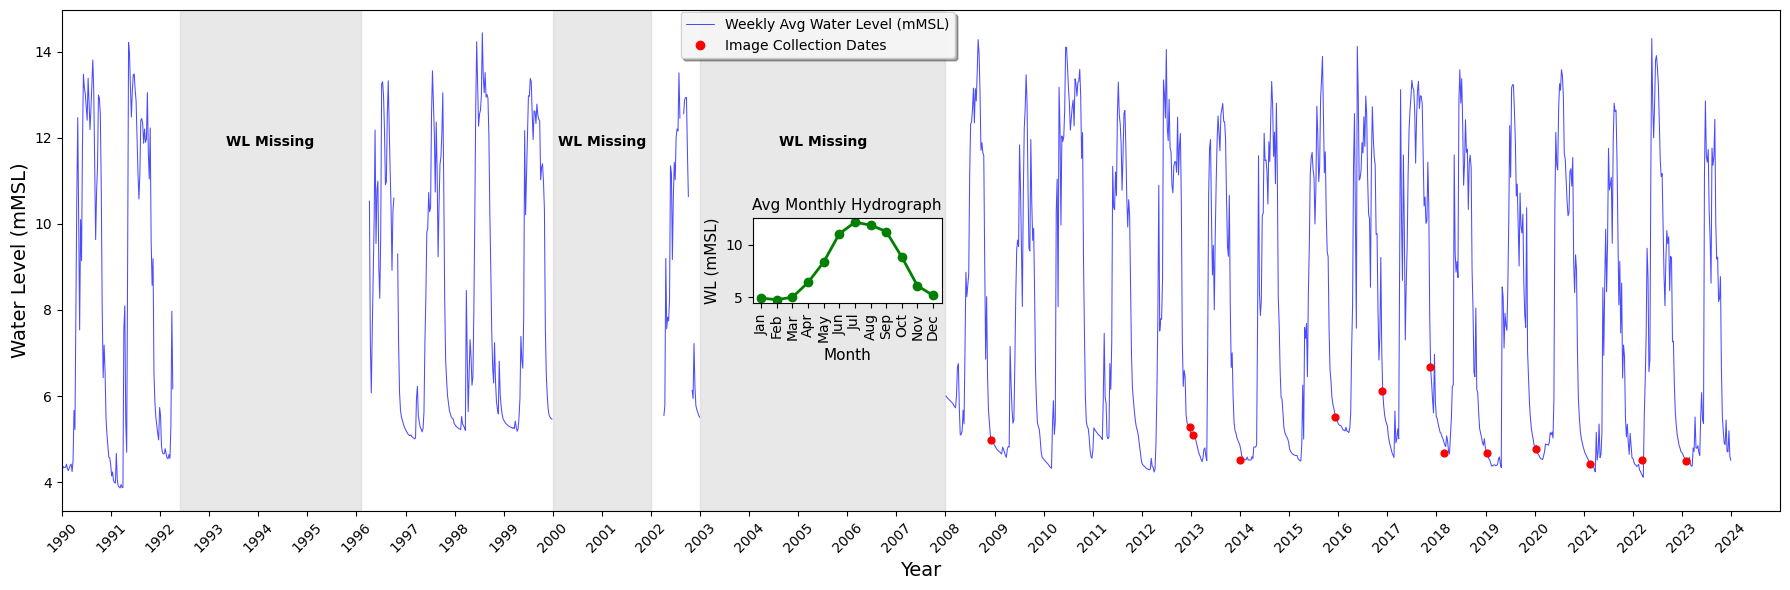

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, YearLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Step 4: Load the Excel file
file_path = '/content/drive/My Drive/colab/fig3_hydrograph/plot_wl.xlsx'
df = pd.read_excel(file_path)

# Step 5: Convert the 'Date Time' column to datetime format
df['Date Time'] = pd.to_datetime(df['Date Time'])

# Step 6: Resample the data to weekly frequency and calculate the average water level
df.set_index('Date Time', inplace=True)  # Set 'Date Time' as the index for resampling
df_weekly = df['WL (mMSL)'].resample('W').mean().reset_index()  # Resample weekly and reset index

# Step 7: Define the periods where data is missing
missing_periods = [
    ('1992-06-01', '1996-02-01'),
    ('2000-01-01', '2001-12-31'),
    ('2003-01-01', '2007-12-31')
]

# Step 8: Plot the main water level data with improved aesthetics
fig, ax = plt.subplots(figsize=(18, 6))  # Create main plot figure

# Create a copy of the weekly resampled DataFrame to handle missing data
df_copy = df_weekly.copy()

# Loop over the missing periods and set the WL values to NaN for those periods to break the line
for start, end in missing_periods:
    mask = (df_copy['Date Time'] >= pd.to_datetime(start)) & (df_copy['Date Time'] <= pd.to_datetime(end))
    df_copy.loc[mask, 'WL (mMSL)'] = None  # Set WL to NaN during the missing periods

# Plot the weekly water level data, with missing periods not connected
ax.plot(df_copy['Date Time'], df_copy['WL (mMSL)'], label='Weekly Average Water Level (WL)', alpha=0.7, color='blue', linewidth=0.75)

# Step 9: Add the new specific data points
new_dates = pd.to_datetime([
    '2008-12-08', '2012-12-24', '2013-01-19', '2014-01-04', '2015-12-09',
    '2016-11-24', '2017-11-11', '2018-02-24', '2019-01-09', '2020-01-12',
    '2021-02-16', '2022-03-08', '2023-02-03'
])  # Dates for the new data points
new_wl_values = [
    4.976, 5.286, 5.096, 4.516, 5.516, 6.128, 6.672, 4.682, 4.676, 4.776,
    4.416, 4.506, 4.49
]  # Water Level values for the new data points

# Plot the new data points without adding them to the legend
for date, value in zip(new_dates, new_wl_values):
    ax.scatter(date, value, color='red', s=24, marker='o', zorder=5)  # Small circle marker

# Step 10: Add shaded regions for missing data periods
for start, end in missing_periods:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='lightgrey', alpha=0.5)

# Step 11: Add labels for missing data
for start, end in missing_periods:
    mid_y_text = (df_copy['WL (mMSL)'].max() + df_copy['WL (mMSL)'].min()) * 0.65  # Adjust text a bit higher
    start_dt = pd.to_datetime(start)
    end_dt = pd.to_datetime(end)
    ax.text((start_dt + (end_dt - start_dt) / 2), mid_y_text, 'WL Missing', color='black', fontsize=10, fontweight='bold',
            horizontalalignment='center', verticalalignment='center')

# Step 12: Set the x-axis limits and format to display all years
ax.set_xlim(pd.to_datetime('1990-01-01'), pd.to_datetime('2024-12-31'))
ax.xaxis.set_major_locator(YearLocator(1))  # Set tick locator to 1-year intervals
ax.xaxis.set_major_formatter(DateFormatter('%Y'))  # Format the x-axis to display the year only
ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels diagonally

# Step 13: Add labels and legend for only the weekly average water level
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Water Level (mMSL)', fontsize=14)

from matplotlib.lines import Line2D

# Create legend elements for the weekly average water level and image collection dates
legend_elements = [
    Line2D([0], [0], color='blue', lw=0.5, label='Weekly Avg Water Level (mMSL)'),
    Line2D([0], [0], marker='o', color='red', markersize=6, linestyle='None', label='Image Collection Dates')
]

# Add the legend to the main plot with flexible placement and consistent formatting
ax.legend(
    handles=legend_elements,
    fontsize=10,            # Legend font size
    loc='center',           # Set location as center (adjustable)
    bbox_to_anchor=(0.44, 0.95),  # Flexible placement with coordinates
    shadow=True,            # Add shadow to legend box
    fancybox=True,          # Enable rounded corners
    framealpha=0.9          # Adjust transparency of the legend box
)


# Step 14: Create the inset for the monthly hydrograph
# Compute the time-averaged monthly hydrograph data
df['Month'] = df.index.month  # Extract month from index
df_monthly = df.groupby('Month')['WL (mMSL)'].mean()  # Average by month (across all years)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Define a function for adding an inset with specific coordinates from the bottom-left corner
def add_inset(ax, x=0.2, y=0.7, width="17%", height="23%"):
    """
    Add an inset plot at specified relative coordinates within the main plot.

    Parameters:
    - ax: The main axes where the inset will be added.
    - x, y: Coordinates (from 0 to 1) specifying the position of the inset's bottom-left corner relative to `ax`.
    - width, height: Width and height of the inset in percentage of the main plot.
    """
    # Use `bbox_to_anchor` for custom positioning
    ax_inset = inset_axes(ax, width=width, height=height, bbox_to_anchor=(x, y, 1, 1), bbox_transform=ax.transAxes, loc='lower left')
    ax_inset.plot(months, df_monthly.values, label='Monthly Hydrograph', color='green', linewidth=2, marker='o')
    ax_inset.set_title('Avg Monthly Hydrograph', fontsize=11)

    # Customize labels and ticks for the inset plot
    ax_inset.set_xlabel('Month', fontsize=11)
    ax_inset.set_ylabel('WL (mMSL)', fontsize=11)
    ax_inset.tick_params(axis='both', which='major', labelsize=10)

    # Set y-axis ticks to only 5 and 10, without decimals
    ax_inset.set_yticks([5, 10])
    ax_inset.set_yticklabels(['5', '10'])

    # Rotate the month names to be vertical for clarity
    ax_inset.set_xticklabels(months, rotation=90)

    return ax_inset


# Call the function with desired position for the inset
add_inset(ax, x=0.398, y=0.4, width="11%", height="17%")  # Adjust x, y, width, height as needed


# Save the plot to a file
output_file_path = '/content/drive/My Drive/colab/fig3_hydrograph/fig3_hydrograph.png'
plt.savefig(output_file_path, dpi=600)  # Save with high resolution (300 DPI)


# Print a confirmation message
print(f"Plot saved to: {output_file_path}")

# Show the plot
plt.tight_layout()
plt.show()



In [ ]:
# Section Extra I: Script to Extract WL (mMSL) Values for a Specific Date from Excel File in Google Colab

import pandas as pd

# File path to the Excel file
file_path = '/content/drive/My Drive/colab/plot_wl/plot_wl.xlsx'

# Load the Excel file
xl = pd.ExcelFile(file_path)

# Load the sheet into a DataFrame (assuming there's only one sheet or you can specify the sheet name)
df = xl.parse(xl.sheet_names[0])

# Convert 'Date Time' column to datetime type to enable easy filtering
df['Date Time'] = pd.to_datetime(df['Date Time'], dayfirst=True, errors='coerce')

# Filter the rows based on the specific date, e.g., '1/3/2005'
specific_date = '02/03/2023'
specific_date = pd.to_datetime(specific_date, dayfirst=True)

# Extract the rows that match the specified date
filtered_df = df[df['Date Time'].dt.date == specific_date.date()]

# Display the WL (mMSL) values for the filtered rows
wl_values = filtered_df['WL (mMSL)']
print("WL (mMSL) values:")
print(wl_values)

# Optionally, you can display the DataFrame itself if you want more details
filtered_df


WL (mMSL) values:
38180    4.42
38181    4.42
38182    4.42
38183    4.42
38184    4.42
Name: WL (mMSL), dtype: float64


,Station ID,Date Time,WL (mMSL)
38180,SW326,2023-03-02 06:00:00,4.42
38181,SW326,2023-03-02 09:00:00,4.42
38182,SW326,2023-03-02 12:00:00,4.42
38183,SW326,2023-03-02 15:00:00,4.42
38184,SW326,2023-03-02 18:00:00,4.42


In [ ]:
# Section Extra II: Script to find the missing data ranges
import pandas as pd

# Load the Excel file
file_path = '/content/drive/My Drive/colab/plot_wl/plot_wl.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet1')

# Convert the 'Date Time' column to datetime format
df['Date Time'] = pd.to_datetime(df['Date Time'])

# Sort the DataFrame by the 'Date Time' column
df = df.sort_values(by='Date Time').reset_index(drop=True)

# Create a date range from the minimum to the maximum date in the data
full_date_range = pd.date_range(start=df['Date Time'].min(), end=df['Date Time'].max())

# Find the missing dates by comparing the full date range with the dates in the data
missing_dates = full_date_range.difference(df['Date Time'])

# Group consecutive missing dates into ranges
def find_missing_ranges(missing_dates):
    missing_ranges = []
    start_date = missing_dates[0]

    for i in range(1, len(missing_dates)):
        if missing_dates[i] - missing_dates[i - 1] != pd.Timedelta(days=1):
            end_date = missing_dates[i - 1]
            missing_ranges.append((start_date, end_date))
            start_date = missing_dates[i]

    # Add the last range
    missing_ranges.append((start_date, missing_dates[-1]))
    return missing_ranges

missing_ranges = find_missing_ranges(missing_dates)

# Print the missing date ranges
for start, end in missing_ranges:
    print(f"Missing data from {start.date()} to {end.date()}")

Missing data from 1991-05-02 to 1991-05-02
Missing data from 1992-04-01 to 1992-06-30
Missing data from 1992-08-01 to 1996-03-31
Missing data from 1996-10-01 to 1996-10-31
Missing data from 1997-10-31 to 1997-10-31
Missing data from 2000-01-01 to 2001-08-15
Missing data from 2002-01-01 to 2002-03-31
Missing data from 2002-08-01 to 2002-08-31
Missing data from 2002-10-01 to 2002-10-31
Missing data from 2003-02-01 to 2007-06-30
Missing data from 2015-12-30 to 2015-12-31
